In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers
from scikeras.wrappers import KerasRegressor

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [2]:
window_size=10

df = pd.read_csv('../Base_Umbilo.csv', sep=';',decimal=',')
df.set_index('Dia', inplace=True)


df = df.drop(['Q_saida',
            'NH_saida',
            'NO_saida',
            'TSS_saida',
            'DBO_saida',
            'TN_saida',
            'TKN_saida',
            'TP_saida',
            'PO_saida',
            'DBO_entrada',
            'DQO_entrada',
            'TKN_entrada',
            'TP_entrada',
            'PO_entrada'],axis=1)

# We will use DQO_saida of the prior timestep to predict DQO_saida
df['DQO_saida_1Dantes'] = df['DQO_saida'].shift(1)
df = df.dropna()
df = df[['Q_entrada', 'NH_entrada', 'TSS_entrada', #'DQO_entrada', 'DBO_entrada', 'TKN_entrada', 'TP_entrada',
       'TN_entrada','DQO_saida_1Dantes','DQO_saida']]
df

,Q_entrada,NH_entrada,TSS_entrada,TN_entrada,DQO_saida_1Dantes,DQO_saida
Dia,,,,,,
0.041667,4766.833372,21.041667,271.208333,34.114167,83.782370,81.485161
0.083333,4814.666743,21.083333,271.416667,34.168333,81.485161,80.156342
0.125000,4862.500115,21.125000,271.625000,34.222500,80.156342,78.986079
0.166667,4910.333486,21.166667,271.833334,34.276667,78.986079,77.894845
0.208334,4958.166858,21.208333,272.041668,34.330834,77.894845,76.857194
...,...,...,...,...,...,...
364.833625,2891.467657,17.166375,173.332750,25.411331,33.155136,33.145931
364.875292,2767.884225,17.124708,173.249416,25.363414,33.145931,33.142325
364.916959,2644.300792,17.083041,173.166083,25.315498,33.142325,33.144707


In [3]:
def df_to_X_y(df, window_size=window_size):
  df_as_np = df.to_numpy()
  X1 = []
  y1 = []
  for i in range(len(df_as_np)-window_size):
  # row = df_as_np[i:i+window_size, :-1]
    row = [r for r in df_as_np[i:i+window_size, :-1]] #Exclude last column (the one to predict)
    X1.append(row)
    label = df_as_np[i+window_size][-1]
    y1.append(label)
  return np.array(X1), np.array(y1)

In [4]:
X, y = df_to_X_y(df)
X.shape, y.shape

((8750, 10, 5), (8750,))

In [5]:
X_training, y_training = X[:7312], y[:7312]
X_val, y_val = X[7312:8031], y[7312:8031]
X_test, y_test = X[8031:], y[8031:]
X_training.shape, y_training.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((7312, 10, 5), (7312,), (719, 10, 5), (719,), (719, 10, 5), (719,))

In [7]:
# Padronização (Standardization) para o y
# Sempre usar os dados de treino apenas para construir o modelo, então transformar o teste com base no treino (como se o teste fossem dados novos)
y_mean = np.mean(y_training, axis=0)
y_std = np.std(y_training, axis=0)
X_mean = np.mean(X_training, axis=0)
X_std = np.std(X_training, axis=0)

standardized_X_training = (X_training - X_mean) / X_std
standardized_X_val = (X_val - X_mean) / X_std
standardized_X_test = (X_test - X_mean) / X_std
standardized_y_training = (y_training - y_mean) / y_std
standardized_y_val = (y_val - y_mean) / y_std
standardized_y_test = (y_test - y_mean) / y_std

Epoch 1/500
229/229 [==============================] - 3s 5ms/step - loss: 0.6004 - root_mean_squared_error: 0.7749 - val_loss: 0.0501 - val_root_mean_squared_error: 0.2238
Epoch 2/500
229/229 [==============================] - 1s 4ms/step - loss: 0.1303 - root_mean_squared_error: 0.3609 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1164
Epoch 3/500
229/229 [==============================] - 1s 4ms/step - loss: 0.0915 - root_mean_squared_error: 0.3025 - val_loss: 0.0100 - val_root_mean_squared_error: 0.0998
Epoch 4/500
229/229 [==============================] - 1s 5ms/step - loss: 0.0647 - root_mean_squared_error: 0.2545 - val_loss: 0.0098 - val_root_mean_squared_error: 0.0989
Epoch 5/500
229/229 [==============================] - 1s 4ms/step - loss: 0.0639 - root_mean_squared_error: 0.2528 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0886
Epoch 6/500
229/229 [==============================] - 1s 5ms/step - loss: 0.0575 - root_mean_squared_error: 0.2397 - val_loss: 0.0052 

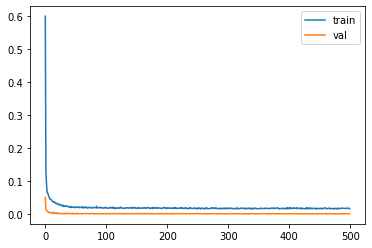

In [11]:
# design LSTM network
model = Sequential()
model.add(LSTM(64, input_shape=(standardized_X_training.shape[1], standardized_X_training.shape[2])))
model.add(Dense(16, 'relu')) 
model.add(Dropout(0.1))
model.add(Dense(16, 'relu'))
model.add(Dropout(0.1))

model.add(Dense(1, 'linear')) #, kernel_initializer='uniform', activation='linear'

# cp = ModelCheckpoint('LSTM_5days/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

# fit network
# history = model.fit(train_X, normalized_y_train, epochs=100, batch_size=50, validation_data=(test_X, normalized_y_test), verbose=2, shuffle=False)
history = model.fit(standardized_X_training, standardized_y_training, validation_data=(standardized_X_val, standardized_y_val), epochs=500) #callbacks=[cp], 

# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [10]:
# from keras.models import load_model

# model = load_model("LSTM_5days.h5")

In [31]:
def predictions(model, X, y, standardized=False):
    predictions = model.predict(X).flatten()
 
    # Revert the standardization
    if standardized==True:
        X = (X * X_std) + X_mean
        y = (y * y_std) + y_mean
        predictions = (predictions * y_std) + y_mean

    df_comparacao = pd.DataFrame(data={'Real':y, 'Predito':predictions })
    df_comparacao['Diferenca_percentual'] = 100*(df_comparacao['Predito'] - df_comparacao['Real'])/df_comparacao['Real']
    df_comparacao.sort_index(inplace=True)
    df_comparacao

    rmse = math.sqrt(mean_squared_error(y, predictions))
    mae  = mean_absolute_error(y, predictions)
    mape = mean_absolute_percentage_error(y, predictions)
    r2   = r2_score(y, predictions)


    df_metricas = pd.DataFrame(data={'RSME':[rmse], 'MAE':[mae], 'MAPE':[mape],'R²':[r2]})
    return df_comparacao, df_metricas

In [32]:
df_comparacao, df_metricas = predictions(model, standardized_X_test, standardized_y_test, standardized=True)
df_metricas

23/23 [==============================] - 0s 2ms/step


,RSME,MAE,MAPE,R²
0,2.864022,2.179993,0.044517,0.990652


In [33]:
df_comparacao

,Real,Predito,Diferenca_percentual
0,82.855864,82.213043,-0.775830
1,82.498896,81.966705,-0.645088
2,82.205463,81.770706,-0.528866
3,81.972441,81.612534,-0.439059
4,81.797515,81.493973,-0.371089
...,...,...,...
714,33.145931,39.645546,19.609087
715,33.142325,39.723740,19.858036
716,33.144707,39.804920,20.094350
717,33.153967,39.889286,20.315273


       RSME       MAE      MAPE        R²
0  2.864022  2.179993  0.044517  0.990652


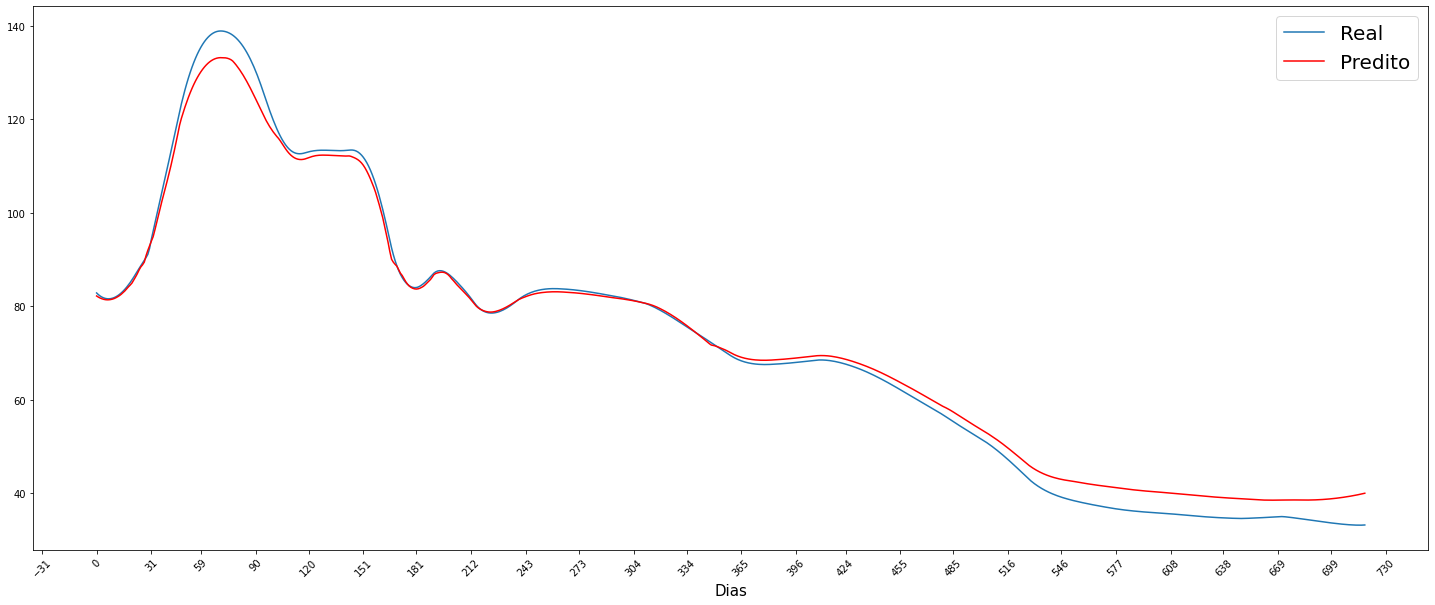

In [34]:
print(df_metricas)
import matplotlib.dates as mdates
# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_comparacao.index, df_comparacao['Real'], label = 'Real')
plt.plot(df_comparacao.index, df_comparacao['Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [35]:
df_comparacao.to_csv("1_4-Previsoes_SIMPLE_LSTM.csv",encoding='utf-8-sig',sep=';',decimal=',')

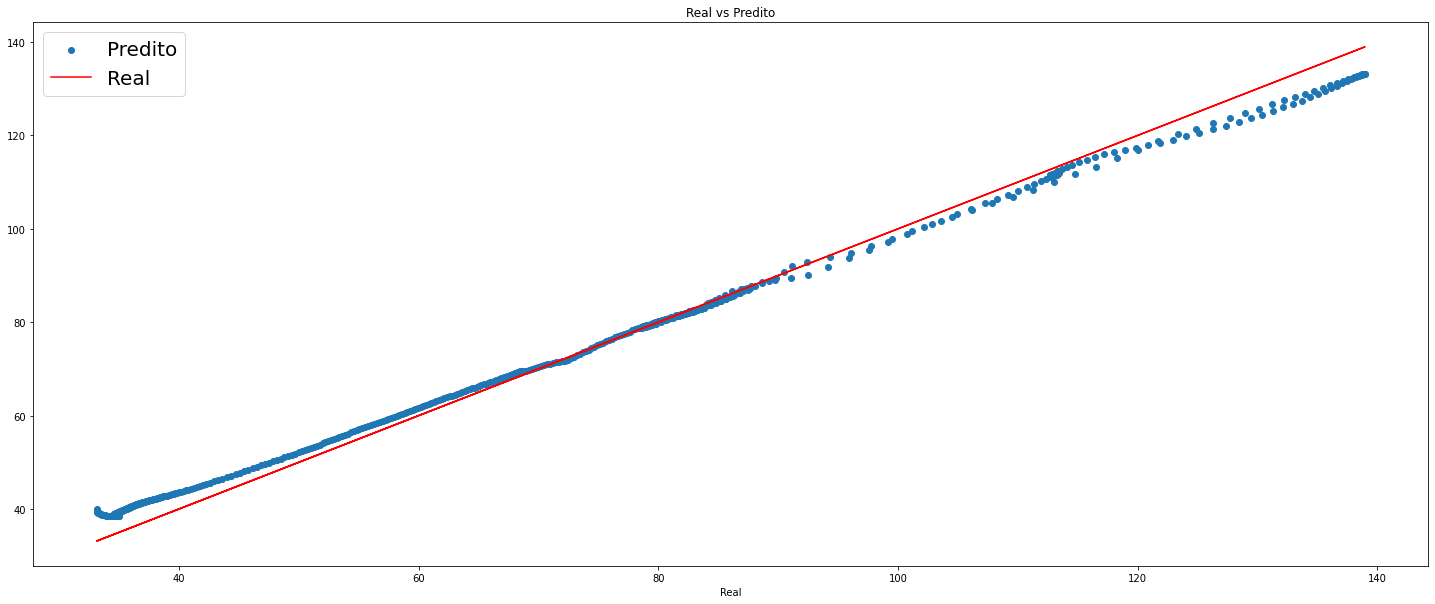

In [36]:
# Visualização gráfica das predições por valores reais
plt.figure(figsize=(25,10))
plt.title('Real vs Predito')
plt.scatter(df_comparacao['Real'], df_comparacao['Predito'], label='Predito')
plt.plot(df_comparacao['Real'],df_comparacao['Real'],c='r', label='Real')
plt.legend(fontsize=20)
plt.xlabel('Previsto')
plt.xlabel('Real')
plt.show()

In [37]:
model.save("LSTM_10h.h5")

In [38]:
# from keras.models import load_model

# model = load_model("LSTM_10h.h5")

# Previsão na base de treino

 49/229 [=====>........................] - ETA: 0s

229/229 [==============================] - 0s 2ms/step
       RSME       MAE      MAPE        R²
0  0.103361  0.057943  0.138126  0.989316


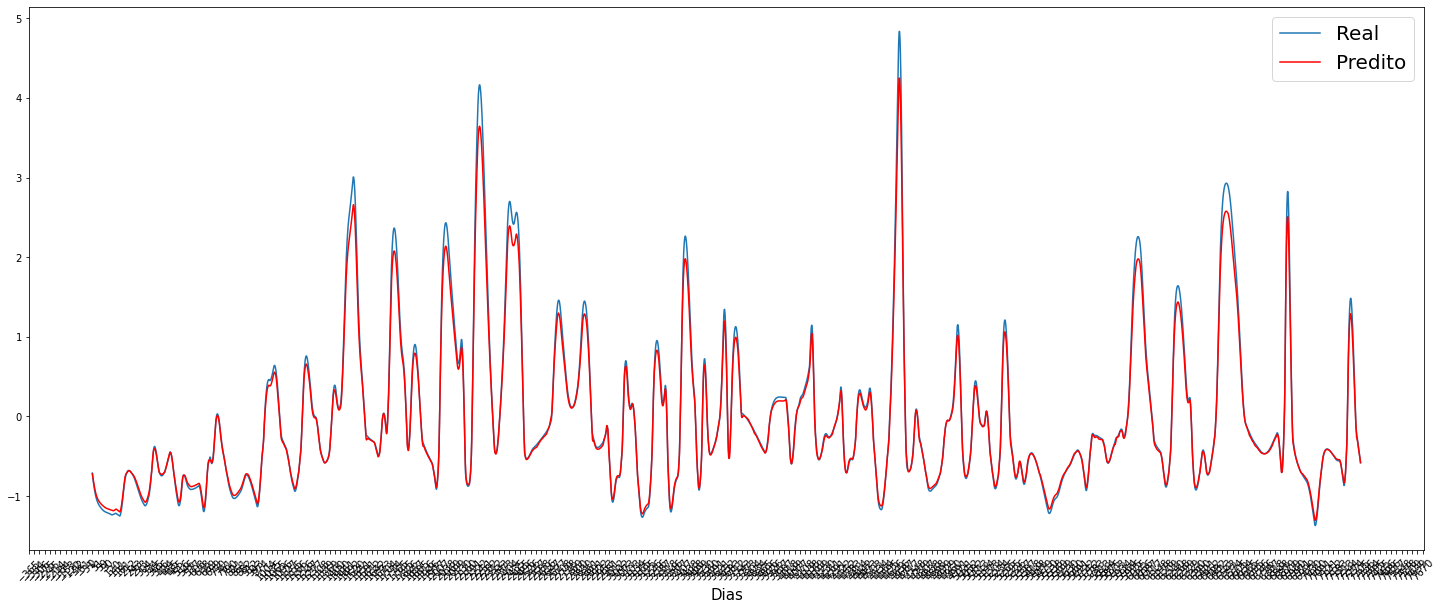

In [39]:
df_train_comparacao, df_train_metricas = predictions(model, standardized_X_training, standardized_y_training)

print(df_train_metricas)

# Visualização gráfica das predições comparadas aos valores reais
fig = plt.figure(figsize=(25,10))
ax = fig.add_subplot(1,1,1) 
# plt.title('', fontsize=25)
plt.plot(df_train_comparacao.index, df_train_comparacao['Real'], label = 'Real')
plt.plot(df_train_comparacao.index, df_train_comparacao['Predito'], label = 'Predito', c='r')
plt.legend(fontsize=20)
plt.xlabel('Dias', fontsize=15)
plt.xticks(fontsize=10, rotation=45)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
# ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%d'))

plt.show()

In [40]:
# Gráfico de cima, queremos os dados só para o melhor modelo (base de treino)
df_train_comparacao.to_csv('2_4-Previsoes_TREINO_S_LSTM.csv',sep=';',decimal=',',encoding='utf-8-sig')

# FEATURE IMPORTANCE

## PDPs and Permutation Importance

In [41]:
print(X_training.min())
print(X_training.max())

8.00111636371675
13259.8061356593


In [42]:
# Calculate baseline metric
baseline_preds = model.predict(standardized_X_test)
baseline_metric = mean_squared_error(standardized_y_test, baseline_preds)

 1/23 [>.............................] - ETA: 0s

23/23 [==============================] - 0s 3ms/step


In [43]:
# Calculate feature importance via permutation importance
n_permutations = 30
feature_importance = np.zeros(standardized_X_test.shape[2])
for _ in range(n_permutations):
    for feature_idx in range(standardized_X_test.shape[2]):
        # Create a copy of the test set with shuffled values for the feature
        shuffled_X_test = standardized_X_test.copy()
        np.random.shuffle(shuffled_X_test[:, :, feature_idx])

        # Compute predictions and metric for the shuffled data
        shuffled_preds = model.predict(shuffled_X_test)
        shuffled_metric = mean_squared_error(standardized_y_test, shuffled_preds)

        # Calculate the feature importance for this permutation
        importance = baseline_metric - shuffled_metric
        feature_importance[feature_idx] += importance

# Average the feature importance over the permutations
feature_importance /= n_permutations

23/23 [==============================] - 0s 2ms/step


In [44]:
# Print the feature importances
for feature_idx, importance in enumerate(feature_importance):
    print(f"{df.columns[feature_idx]}: Importance = {abs(importance)}")

Q_entrada: Importance = 0.0006911505142623886
NH_entrada: Importance = 0.011997599668311045
TSS_entrada: Importance = 0.025711247506627476
TN_entrada: Importance = 0.13762102525133527
DQO_saida_1Dantes: Importance = 0.6824312259763984


In [45]:
importance_df = pd.DataFrame(feature_importance,index=df.columns[:-1])
importance_df = importance_df.sort_values(by=0)
importance_df = importance_df/importance_df.sum()
importance_df

,0
DQO_saida_1Dantes,0.794955
TN_entrada,0.160313
TSS_entrada,0.029951
NH_entrada,0.013976
Q_entrada,0.000805


In [46]:
importance_df.to_csv('3_4-Permutation_Importance_S_LSTM.csv',sep=';',decimal=',',encoding='utf-8-sig')

In [47]:
def calculate_pdp(feature_idx):
    # Select the feature for which you want to calculate the partial dependence
    selected_feature = standardized_X_training[:, :, feature_idx]

    # Create a grid of values for the selected feature
    grid_values = np.linspace(selected_feature.min(), selected_feature.max(), num=100)

    # Create a copy of the prepared dataset
    modified_data = np.copy(standardized_X_training)

    pdp_values = []
    
    # Replace feature values and generate predictions for each grid value
    for value in grid_values:
        modified_data[:, :, feature_idx] = value
        modified_predictions = model.predict(modified_data)

        # Calculate the average predictions
        average_predictions = np.mean(modified_predictions)

        pdp_values.append(average_predictions)

    return pdp_values

  1/229 [..............................] - ETA: 3s

229/229 [==============================] - 0s 2ms/step


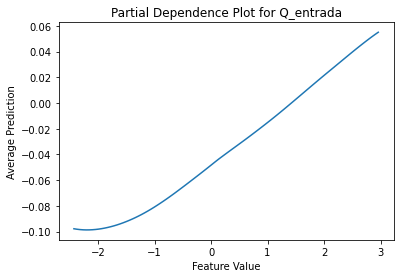

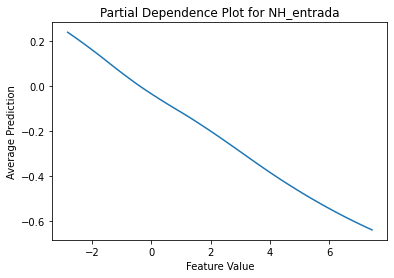

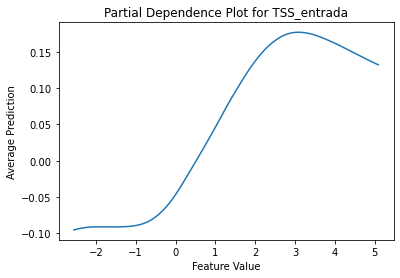

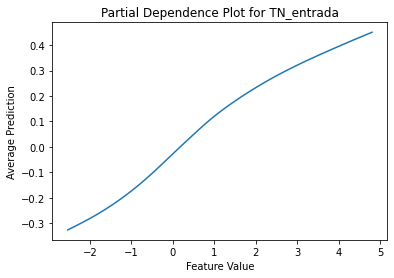

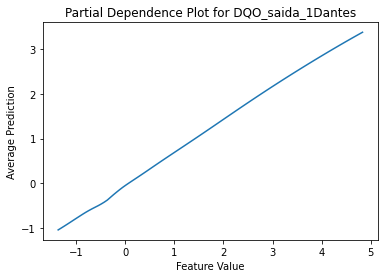

In [48]:
all_pdp_values = []
num_features = standardized_X_training.shape[2]  # Number of features in the data
pdp_intervals = []

# Calculate PDP values for all features
for feature_idx in range(num_features):
    pdp_values = calculate_pdp(feature_idx)
    all_pdp_values.append(pdp_values)
    
# Plot the PDPs for all features
for feature_idx, pdp_values in enumerate(all_pdp_values):
    grid_values = np.linspace(standardized_X_training[:, :, feature_idx].min(), standardized_X_training[:, :, feature_idx].max(), num=100)
    pdp_intervals.append(grid_values)
    
    plt.plot(grid_values, pdp_values)
    plt.xlabel('Feature Value')
    plt.ylabel('Average Prediction')
    plt.title('Partial Dependence Plot for {}'.format(df.columns[feature_idx]))
    plt.show()

In [49]:
# Values from each variable which have been used to calculate the PDPs
df_pdp_intervals = pd.DataFrame(pdp_intervals).T
df_pdp_intervals.columns = df.columns[:-1]
df_pdp_intervals = df_pdp_intervals.add_suffix('_values')


# PDP values for each variable
df_pdp_values = pd.DataFrame(all_pdp_values).T
df_pdp_values.columns = df.columns[:-1]
df_pdp_values = df_pdp_values.add_suffix('_importance')


# Interleave the columns from df_pdp_intervals and df_pdp_values
df_pdp = pd.concat([df_pdp_intervals, df_pdp_values], axis=1)
combined_columns = np.ravel(list(zip(df_pdp.columns[:df_pdp_intervals.shape[1]], df_pdp.columns[df_pdp_intervals.shape[1]:])))

# Rearrange the columns
df_pdp = df_pdp[combined_columns]

df_pdp.to_csv("4_4-PDPs_S_LSTM.csv",sep=';',decimal=',',encoding='utf-8-sig')

df_pdp

,Q_entrada_values,Q_entrada_importance,NH_entrada_values,NH_entrada_importance,TSS_entrada_values,TSS_entrada_importance,TN_entrada_values,TN_entrada_importance,DQO_saida_1Dantes_values,DQO_saida_1Dantes_importance
0,-2.426503,-0.097814,-2.824123,0.240239,-2.551816,-0.095734,-2.535982,-0.326902,-1.370103,-1.044108
1,-2.372101,-0.098190,-2.720387,0.230760,-2.474590,-0.094652,-2.461890,-0.320997,-1.307426,-1.001747
2,-2.317698,-0.098465,-2.616651,0.221178,-2.397363,-0.093718,-2.387798,-0.314993,-1.244749,-0.958559
3,-2.263296,-0.098640,-2.512915,0.211466,-2.320137,-0.092952,-2.313706,-0.308886,-1.182071,-0.914667
4,-2.208893,-0.098719,-2.409179,0.201641,-2.242911,-0.092346,-2.239614,-0.302669,-1.119394,-0.870077
...,...,...,...,...,...,...,...,...,...,...
95,2.741728,0.048127,7.030781,-0.614999,4.784677,0.140724,4.502757,0.430799,4.584243,3.227297
96,2.796131,0.049952,7.134517,-0.621530,4.861903,0.138601,4.576849,0.435855,4.646920,3.266320
97,2.850533,0.051730,7.238253,-0.627982,4.939129,0.136522,4.650941,0.440886,4.709597,3.305086
98,2.904935,0.053451,7.341989,-0.634358,5.016355,0.134488,4.725033,0.445896,4.772275,3.343585
